In [46]:
# change directory location if needed:    
import pandas as pd
import numpy as np
import cmlreaders as cml
data_dir = "/scratch/new_courier_pilot/" ## pilot data directory
# data_dir = "/scratch/EFRCourier_reports/" ## hospital data directory
time_window=10000 # you can chose how long do you want to visualize the data
exp = 'EFRCourierOpenLoop'
whole_df = cml.CMLReader.get_data_index()

# Define the experiment
exp = 'EFRCourierOpenLoop'

# Get unique subjects for the experiment
subjects = whole_df.query('experiment == @exp')['subject'].unique()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import argparse
import glob
import cmlreaders as cml
import json
from matplotlib.ticker import FuncFormatter
import warnings
import numpy as np
import pandas as pd

# Get the full data index
whole_df = cml.CMLReader.get_data_index()

# Define the experiment
exp = 'EFRCourierOpenLoop'

# Get unique subjects for the experiment
subjects = whole_df.query('experiment == @exp')['subject'].unique()

# Initialize results storage
results = []

# Loop through each subject
for subject in subjects:
    print(f"Processing subject: {subject}")
    
    # Get subject data
    sub_df = whole_df.query('experiment == @exp and subject == @subject')
    
    # Get all sessions for this subject
    sessions = sub_df['session'].unique()
    
    # Loop through each session
    for session in sessions:
        print(f"  Processing session: {session}")
        
        try:
            # Create reader for this subject and session
            reader = cml.CMLReader(subject, exp, session=session)
            evs = reader.load('task_events')
            
            # Find wordlist indices
            evs_wordlist_indice = evs[evs['type'] == 'WORDS'].index - 1
            
            # Extract pulse frequency data and word data types
            pulse_freq_data = []
            word_data_type = []
            
            for i in range(len(evs['stim_params'])):
                freq_data = evs['stim_params'].iloc[i]['burst_freq']
                word_data = evs['type'].iloc[i]
                pulse_freq_data.append(freq_data)
                word_data_type.append(word_data)
            
            # Find indices for different stimulation frequencies
            indices_with_8 = np.where(np.array(pulse_freq_data) == 8)[0] + 1
            indices_with_8 = indices_with_8.tolist()
            
            indices_with_3 = np.where(np.array(pulse_freq_data) == 3)[0] + 1
            indices_with_3 = indices_with_3.tolist()
            
            indices_with_no = np.where(np.array(pulse_freq_data)[:-1] == -1)[0] + 1
            indices_with_no = indices_with_no.tolist()
            
            # Filter events by stimulation type
            result_8HZ_encoding = evs[(evs.index.isin(indices_with_8))]
            result_3HZ_encoding = evs[(evs.index.isin(indices_with_3))]
            result_no_encoding = evs[(evs.index.isin(indices_with_no))]
            
            # Get stimulated words for each condition
            Stimuli_words_8 = result_8HZ_encoding[result_8HZ_encoding['type'] == 'WORD']
            Stimuli_words_3 = result_3HZ_encoding[result_3HZ_encoding['type'] == 'WORD']
            Stimuli_words_no = result_no_encoding[result_no_encoding['type'] == 'WORD']
            
            # Calculate recall rates
            if len(Stimuli_words_no) > 0:
                Recalled_results_no = Stimuli_words_no['recalled'].sum() / len(Stimuli_words_no['recalled'])
            else:
                Recalled_results_no = np.nan
                
            if len(Stimuli_words_3) > 0:
                Recalled_results_3hz = Stimuli_words_3['recalled'].sum() / len(Stimuli_words_3['recalled'])
            else:
                Recalled_results_3hz = np.nan
                
            if len(Stimuli_words_8) > 0:
                Recalled_results_8hz = Stimuli_words_8['recalled'].sum() / len(Stimuli_words_8['recalled'])
            else:
                Recalled_results_8hz = np.nan
            
            # Store results
            session_result = {
                'subject': subject,
                'session': session,
                'recall_no_stim': Recalled_results_no,
                'recall_3hz': Recalled_results_3hz,
                'recall_8hz': Recalled_results_8hz,
                'n_words_no_stim': len(Stimuli_words_no),
                'n_words_3hz': len(Stimuli_words_3),
                'n_words_8hz': len(Stimuli_words_8)
            }
            
            results.append(session_result)
            
            print(f"    No stim recall: {Recalled_results_no:.3f} ({len(Stimuli_words_no)} words)")
            print(f"    3Hz recall: {Recalled_results_3hz:.3f} ({len(Stimuli_words_3)} words)")
            print(f"    8Hz recall: {Recalled_results_8hz:.3f} ({len(Stimuli_words_8)} words)")
            
        except Exception as e:
            print(f"    Error processing session {session}: {str(e)}")
            continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display summary statistics
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)

if len(results_df) > 0:
    print(f"Total subjects processed: {results_df['subject'].nunique()}")
    print(f"Total sessions processed: {len(results_df)}")
    print(f"\nMean recall rates across all sessions:")
    print(f"No stimulation: {results_df['recall_no_stim'].mean():.3f} ± {results_df['recall_no_stim'].std():.3f}")
    print(f"3Hz stimulation: {results_df['recall_3hz'].mean():.3f} ± {results_df['recall_3hz'].std():.3f}")
    print(f"8Hz stimulation: {results_df['recall_8hz'].mean():.3f} ± {results_df['recall_8hz'].std():.3f}")
    
    # Display the results DataFrame
    print(f"\nDetailed results:")
    print(results_df.to_string(index=False))
else:
    print("No results to display. Check for errors in processing.")


Processing subject: FBG490
  Processing session: 0
    No stim recall: 0.562 (32 words)
    3Hz recall: 0.667 (12 words)
    8Hz recall: 0.625 (16 words)
  Processing session: 1
    No stim recall: 0.765 (34 words)
    3Hz recall: 0.545 (11 words)
    8Hz recall: 0.667 (15 words)
  Processing session: 2
    No stim recall: 0.824 (34 words)
    3Hz recall: 0.818 (11 words)
    8Hz recall: 0.333 (15 words)
Processing subject: FBG491
  Processing session: 1
    No stim recall: 0.367 (30 words)
    3Hz recall: 0.444 (18 words)
    8Hz recall: 0.500 (12 words)
  Processing session: 2
    No stim recall: 0.567 (30 words)
    3Hz recall: 0.611 (18 words)
    8Hz recall: 0.417 (12 words)
Processing subject: FR491
  Processing session: 1
    Error processing session 1: Unable to find the requested file in any of the expected locations:
 /protocols/pyfr/subjects/FR491/experiments/EFRCourierOpenLoop/sessions/1/behavioral/current_processed/task_events.json
/data/events/pyFR/FR491_None_events.mat
 

In [7]:
df_filtered = results_df.drop(index=[10])  
df_filtered

,subject,session,recall_no_stim,recall_3hz,recall_8hz,n_words_no_stim,n_words_3hz,n_words_8hz
0,FBG490,0,0.562500,0.666667,0.625000,32,12,16
1,FBG490,1,0.764706,0.545455,0.666667,34,11,15
2,FBG490,2,0.823529,0.818182,0.333333,34,11,15
3,FBG491,1,0.366667,0.444444,0.500000,30,18,12
4,FBG491,2,0.566667,0.611111,0.416667,30,18,12
5,R1620J,3,0.333333,0.333333,0.416667,33,15,12
6,R1620J,4,0.290323,0.352941,0.083333,31,17,12
7,R1653J,0,0.333333,0.416667,0.250000,24,12,12
8,R1653J,1,0.300000,0.500000,0.166667,30,12,18
9,R1653J,2,0.266667,0.222222,0.000000,30,18,12


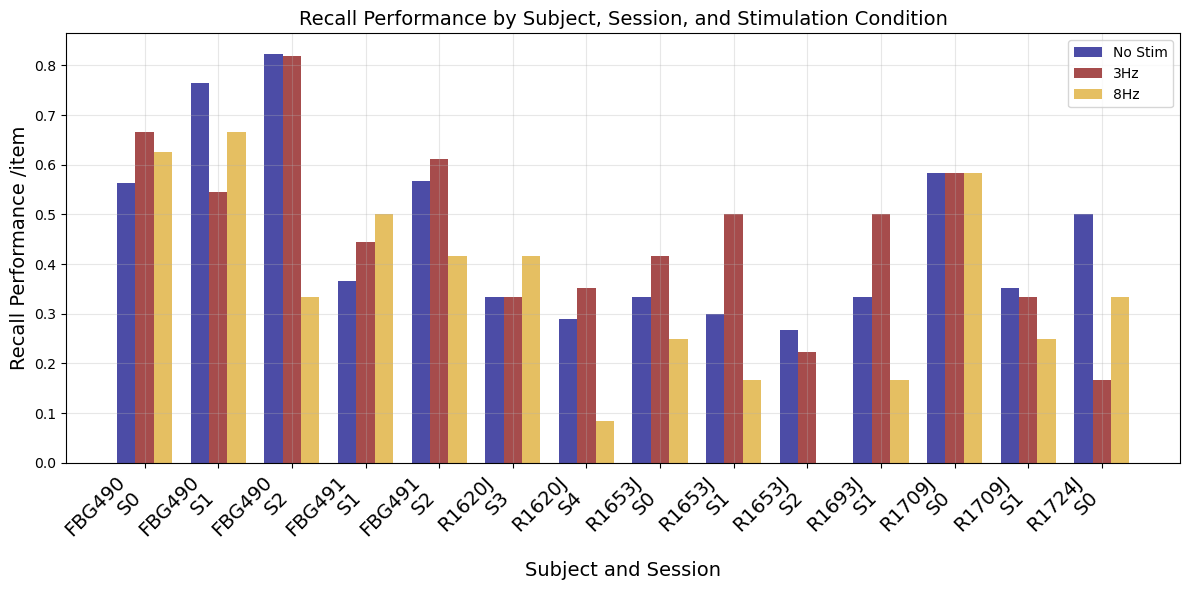

In [47]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
results_df=df_filtered
# Get unique subjects
subjects = results_df['subject'].unique()
x_positions = []
labels = []

# Plot data for each subject and session
x_pos = 0
for subject in subjects:
    subject_data = results_df[results_df['subject'] == subject]
    
    for _, row in subject_data.iterrows():
        # Plot the three conditions
        ax.bar(x_pos - 0.25, row['recall_no_stim'], width=0.25, label='No Stim' if x_pos == 0 else "", color= 'Navy', alpha=0.7)
        ax.bar(x_pos, row['recall_3hz'], width=0.25, label='3Hz' if x_pos == 0 else "", color='maroon', alpha=0.7)
        ax.bar(x_pos + 0.25, row['recall_8hz'], width=0.25, label='8Hz' if x_pos == 0 else "", color='goldenrod', alpha=0.7)
        
        # Store position and label
        x_positions.append(x_pos)
        labels.append(f"{subject}\nS{row['session']}")
        
        x_pos += 1

# Customize the plot
ax.set_xlabel('Subject and Session', fontsize=14)
ax.set_ylabel('Recall Performance /item', fontsize=14)
ax.set_title('Recall Performance by Subject, Session, and Stimulation Condition', fontsize=14)
ax.set_xticks(x_positions)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("recall_rate_during_Encoding.pdf", 
           transparent=True,      # Transparent background
           bbox_inches='tight',   # Removes extra whitespace
           pad_inches=0.08,       # Small padding around the figure
           format='pdf')    
plt.show()

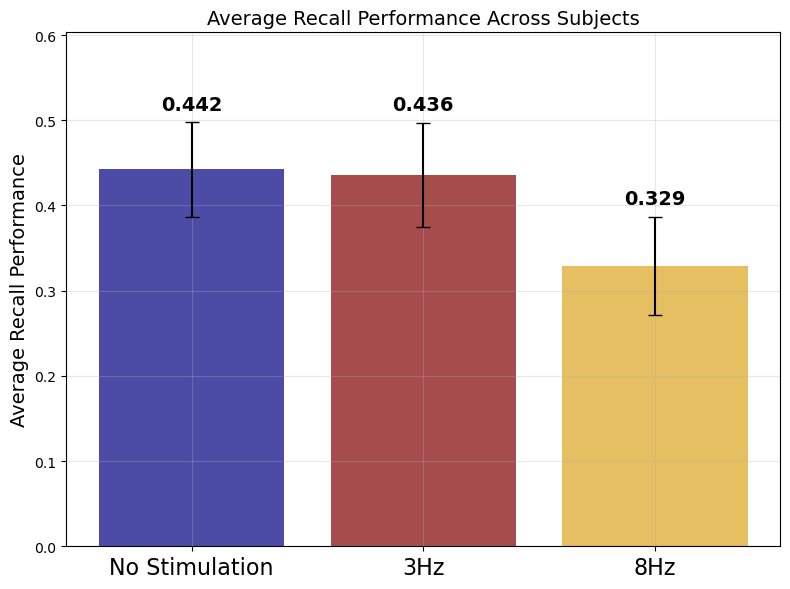

Average Recall Performance/item (by subject means):
No Stimulation: 0.442 ± 0.055
3Hz Stimulation: 0.436 ± 0.061
8Hz Stimulation: 0.329 ± 0.057

Number of subjects: 7


In [73]:
subject_means = results_df.groupby('subject')[['recall_no_stim', 'recall_3hz', 'recall_8hz']].mean()

# Calculate averages across subjects (now using subject means)
avg_no_stim = subject_means['recall_no_stim'].mean()
avg_3hz = subject_means['recall_3hz'].mean()
avg_8hz = subject_means['recall_8hz'].mean()

# Calculate standard errors across subjects
std_no_stim = subject_means['recall_no_stim'].std() / np.sqrt(len(subject_means))
std_3hz = subject_means['recall_3hz'].std() / np.sqrt(len(subject_means))
std_8hz = subject_means['recall_8hz'].std() / np.sqrt(len(subject_means))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
conditions = ['No Stimulation', '3Hz', '8Hz']
means = [avg_no_stim, avg_3hz, avg_8hz]
errors = [std_no_stim, std_3hz, std_8hz]
colors = ['Navy', 'maroon', 'goldenrod']

bars = ax.bar(conditions, means, color=colors, alpha=0.7, capsize=5)
ax.errorbar(conditions, means, yerr=errors, fmt='none', color='black', capsize=5)

# Add value labels on bars
for i, (bar, mean) in enumerate(zip(bars, means)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + errors[i] + 0.01, 
            f'{mean:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=14)

# Customize the plot
ax.set_ylabel('Average Recall Performance', fontsize=14)
ax.set_title('Average Recall Performance Across Subjects', fontsize=14)
ax.set_ylim(0, max(means) + max(errors) + 0.1)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', labelsize=16)
plt.tight_layout()
plt.savefig("'Average_Recall_Performance_Across_Subjects.pdf", 
           transparent=True,      # Transparent background
           bbox_inches='tight',   # Removes extra whitespace
           pad_inches=0.08,       # Small padding around the figure
           format='pdf')    
plt.show()

# Print the exact values
print(f"Average Recall Performance/item (by subject means):")
print(f"No Stimulation: {avg_no_stim:.3f} ± {std_no_stim:.3f}")
print(f"3Hz Stimulation: {avg_3hz:.3f} ± {std_3hz:.3f}")
print(f"8Hz Stimulation: {avg_8hz:.3f} ± {std_8hz:.3f}")
print(f"\nNumber of subjects: {len(subject_means)}")

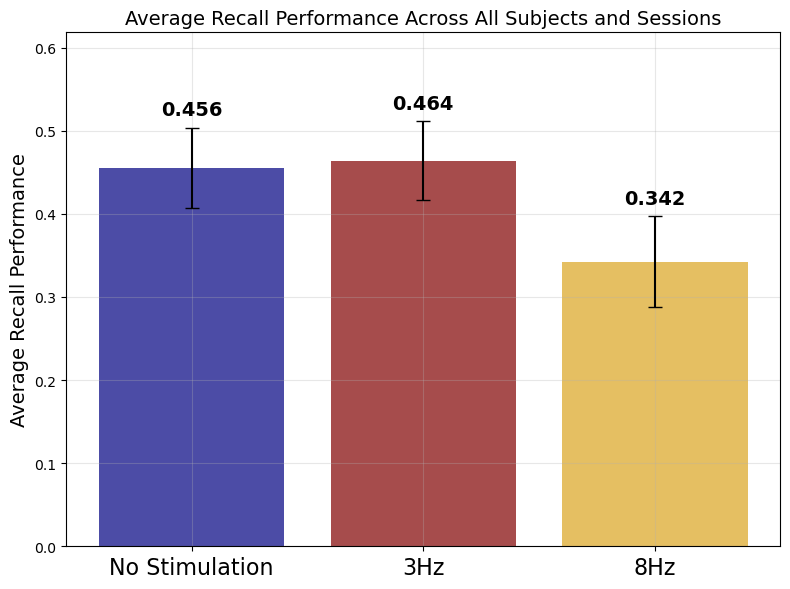

Average Recall Performance:
No Stimulation: 0.456 ± 0.048
3Hz Stimulation: 0.464 ± 0.047
8Hz Stimulation: 0.342 ± 0.055


In [40]:

# Calculate averages across all subjects and sessions
avg_no_stim = results_df['recall_no_stim'].mean()
avg_3hz = results_df['recall_3hz'].mean()
avg_8hz = results_df['recall_8hz'].mean()

# Calculate standard errors
std_no_stim = results_df['recall_no_stim'].std() / np.sqrt(len(results_df))
std_3hz = results_df['recall_3hz'].std() / np.sqrt(len(results_df))
std_8hz = results_df['recall_8hz'].std() / np.sqrt(len(results_df))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

conditions = ['No Stimulation', '3Hz', '8Hz']
means = [avg_no_stim, avg_3hz, avg_8hz]
errors = [std_no_stim, std_3hz, std_8hz]
colors = ['Navy', 'maroon', 'goldenrod']

bars = ax.bar(conditions, means, color=colors, alpha=0.7, capsize=5)
ax.errorbar(conditions, means, yerr=errors, fmt='none', color='black', capsize=5)

# Add value labels on bars
for i, (bar, mean) in enumerate(zip(bars, means)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + errors[i] + 0.01, 
            f'{mean:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=14)

# Customize the plot
ax.set_ylabel('Average Recall Performance', fontsize=14)
ax.set_title('Average Recall Performance Across All Subjects and Sessions', fontsize=14)
ax.set_ylim(0, max(means) + max(errors) + 0.1)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', labelsize=16)  # Change x-axis label size here
plt.tight_layout()
plt.show()

# Print the exact values
print(f"Average Recall Performance/item:")
print(f"No Stimulation: {avg_no_stim:.3f} ± {std_no_stim:.3f}")
print(f"3Hz Stimulation: {avg_3hz:.3f} ± {std_3hz:.3f}")
print(f"8Hz Stimulation: {avg_8hz:.3f} ± {std_8hz:.3f}")

In [54]:
results_df=df_filtered
recall_cols = ['recall_no_stim', 'recall_3hz', 'recall_8hz']
n_words_cols = ['n_words_no_stim', 'n_words_3hz', 'n_words_8hz']

# Create separate dataframes for recall rates and word counts
recall_long = pd.melt(results_df, 
                     id_vars=['subject', 'session'],
                     value_vars=recall_cols,
                     var_name='condition_raw', 
                     value_name='recall_rate')

n_words_long = pd.melt(results_df,
                      id_vars=['subject', 'session'], 
                      value_vars=n_words_cols,
                      var_name='condition_raw_n',
                      value_name='n_words')

# Clean up condition names
condition_mapping = {
    'recall_no_stim': 'no_stim',
    'recall_3hz': '3hz', 
    'recall_8hz': '8hz'
}

recall_long['condition'] = recall_long['condition_raw'].map(condition_mapping)

# Add word counts (matching by position)
recall_long['n_words'] = n_words_long['n_words'].values

# Remove rows with NaN recall rates or zero words
clean_data = recall_long.dropna(subset=['recall_rate'])
clean_data = clean_data[clean_data['n_words'] > 0]

# Create dummy variables for conditions (with no_stim as reference)
clean_data['condition_3hz'] = (clean_data['condition'] == '3hz').astype(int)
clean_data['condition_8hz'] = (clean_data['condition'] == '8hz').astype(int)

# Convert subject to string to ensure proper grouping
clean_data['subject'] = clean_data['subject'].astype(str)
clean_data['session'] = clean_data['session'].astype(str)

In [55]:
clean_data

,subject,session,condition_raw,recall_rate,condition,n_words,condition_3hz,condition_8hz
0,FBG490,0,recall_no_stim,0.562500,no_stim,32,0,0
1,FBG490,1,recall_no_stim,0.764706,no_stim,34,0,0
2,FBG490,2,recall_no_stim,0.823529,no_stim,34,0,0
3,FBG491,1,recall_no_stim,0.366667,no_stim,30,0,0
4,FBG491,2,recall_no_stim,0.566667,no_stim,30,0,0
5,R1620J,3,recall_no_stim,0.333333,no_stim,33,0,0
6,R1620J,4,recall_no_stim,0.290323,no_stim,31,0,0
7,R1653J,0,recall_no_stim,0.333333,no_stim,24,0,0
8,R1653J,1,recall_no_stim,0.300000,no_stim,30,0,0
9,R1653J,2,recall_no_stim,0.266667,no_stim,30,0,0


In [65]:
model1 = mixedlm("recall_rate ~ condition_3hz + condition_8hz", 
                 clean_data, 
                 groups=clean_data["subject"],
                 re_formula="1")

result = model1.fit()
print(result.summary())
# compare with this two methods, the first one give me a better control for the baseline variable to chose. 
#model2 = mixedlm("recall_rate ~ C(condition)", 
 #                clean_data, 
  #               groups=clean_data["subject"],
   #              re_formula="1")
#result1 = model2.fit()


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: recall_rate
No. Observations: 42      Method:             REML       
No. Groups:       7       Scale:              0.0169     
Min. group size:  3       Log-Likelihood:     14.7637    
Max. group size:  9       Converged:          Yes        
Mean group size:  6.0                                    
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.441    0.060  7.406 0.000  0.324  0.558
condition_3hz   0.008    0.049  0.170 0.865 -0.088  0.105
condition_8hz  -0.113    0.049 -2.303 0.021 -0.210 -0.017
Group Var       0.016    0.087                           



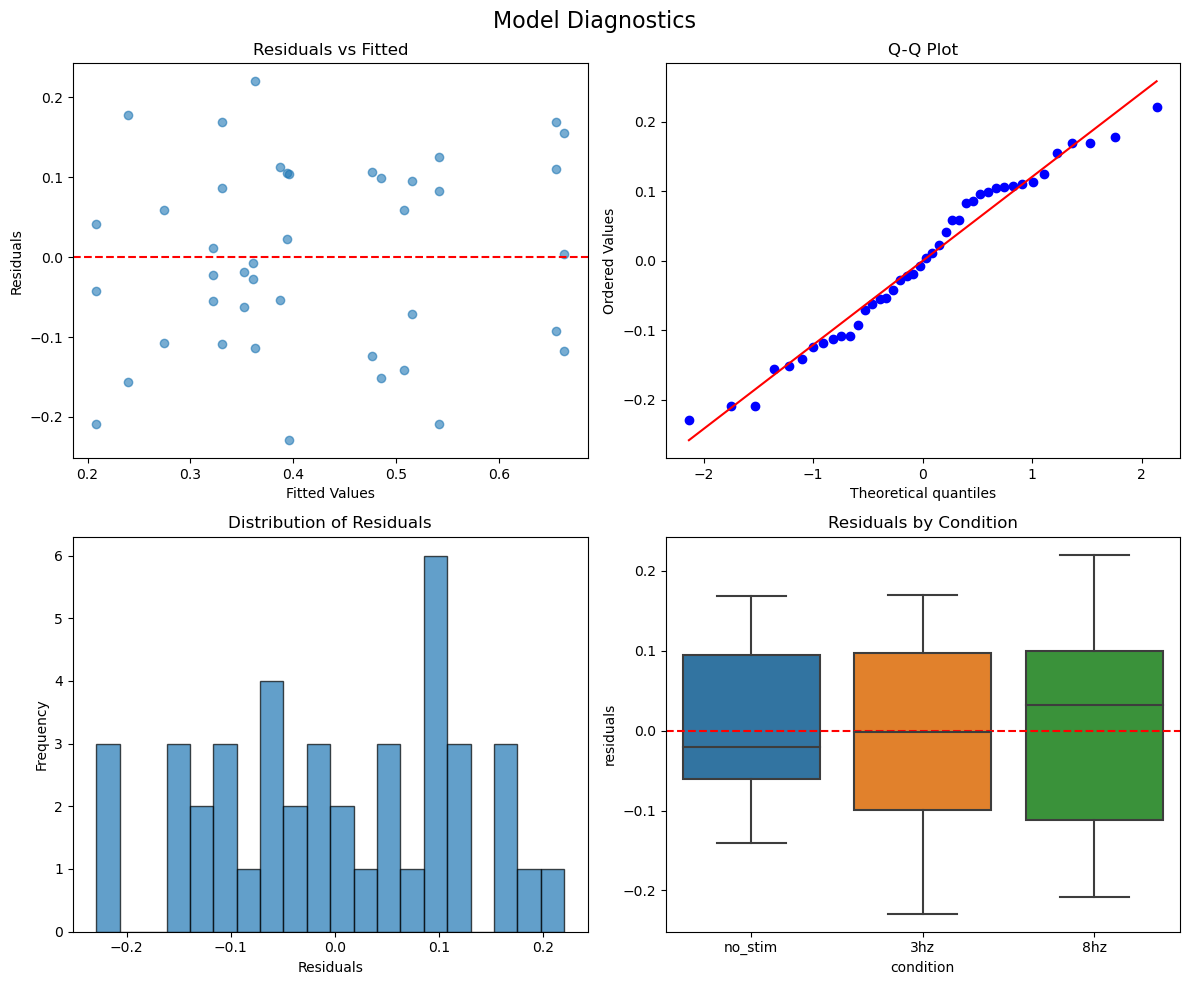

In [67]:
fitted_values = result.fittedvalues
residuals = result.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Model Diagnostics', fontsize=16)

# 1. Residuals vs Fitted
axes[0,0].scatter(fitted_values, residuals, alpha=0.6)
axes[0,0].axhline(y=0, color='r', linestyle='--')
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Fitted')

# 2. Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot')

# 3. Histogram of residuals
axes[1,0].hist(residuals, bins=20, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Residuals')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Residuals')

# 4. Residuals by condition
data_with_resid = data.copy()
data_with_resid['residuals'] = residuals

sns.boxplot(data=data_with_resid, x='condition', y='residuals', ax=axes[1,1])
axes[1,1].set_title('Residuals by Condition')
axes[1,1].axhline(y=0, color='r', linestyle='--')
plt.savefig("ModelDisagnostics_rate_during_Encoding.pdf", 
           transparent=True,      # Transparent background
           bbox_inches='tight',   # Removes extra whitespace
           pad_inches=0.08,       # Small padding around the figure
           format='pdf')   
plt.tight_layout()
plt.show()


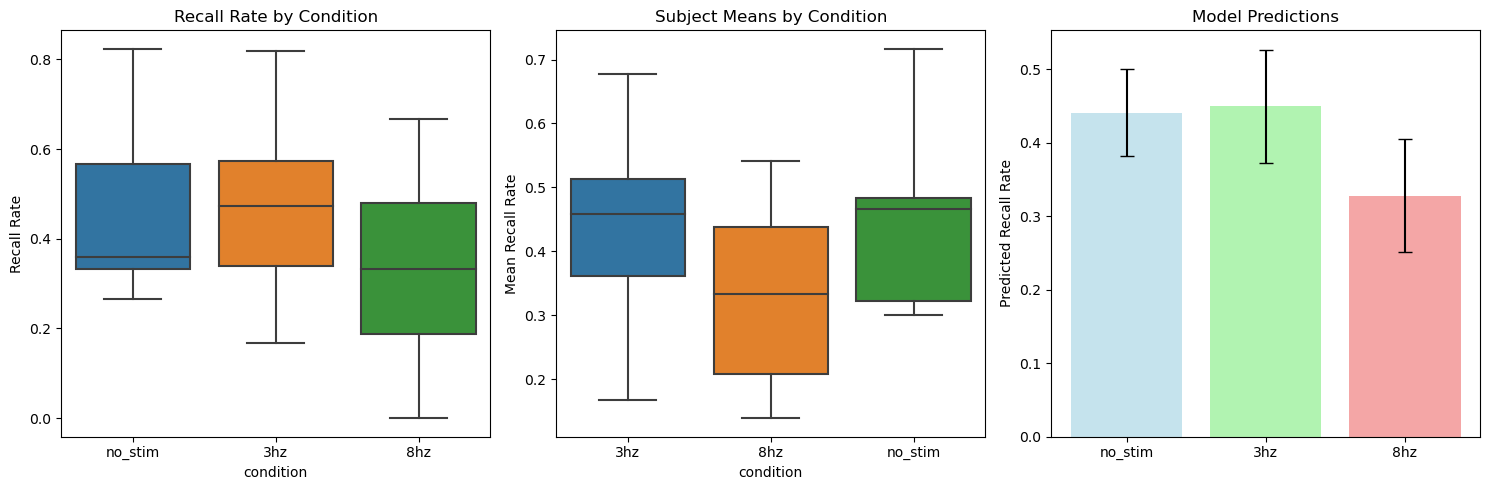

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Raw data by condition
sns.boxplot(data=data, x='condition', y='recall_rate', ax=axes[0])
axes[0].set_title('Recall Rate by Condition')
axes[0].set_ylabel('Recall Rate')

# 2. Subject-wise means
subject_means = data.groupby(['subject', 'condition'])['recall_rate'].mean().reset_index()
sns.boxplot(data=subject_means, x='condition', y='recall_rate', ax=axes[1])
axes[1].set_title('Subject Means by Condition')
axes[1].set_ylabel('Mean Recall Rate')

# 3. Model predictions
conditions = ['no_stim', '3hz', '8hz']
coef = result.params

# Extract coefficients (intercept is no_stim condition)
pred_no_stim = coef['Intercept']
pred_3hz = coef['Intercept'] + coef['condition_3hz']
pred_8hz = coef['Intercept'] + coef['condition_8hz']

predictions = [pred_no_stim, pred_3hz, pred_8hz]

axes[2].bar(conditions, predictions, alpha=0.7, 
           color=['lightblue', 'lightgreen', 'lightcoral'])
axes[2].set_title('Model Predictions')
axes[2].set_ylabel('Predicted Recall Rate')

# Add error bars using standard errors
se_no_stim = result.bse['Intercept']
se_3hz = np.sqrt(result.bse['Intercept']**2 + result.bse['condition_3hz']**2)
se_8hz = np.sqrt(result.bse['Intercept']**2 + result.bse['condition_8hz']**2)

errors = [se_no_stim, se_3hz, se_8hz]
axes[2].errorbar(conditions, predictions, yerr=errors, 
                fmt='none', color='black', capsize=5)

plt.tight_layout()
plt.show()

In [71]:
 coef['Intercept']

0.4410972382828728

In [74]:
coef = result.params
pvalues = result.pvalues
conf_int = result.conf_int()

print(f"Baseline recall rate (no stimulation): {coef['Intercept']:.4f}")
print(f"95% CI: [{conf_int.iloc[0,0]:.4f}, {conf_int.iloc[0,1]:.4f}]")
print()

print(f"3Hz vs No Stimulation:")
print(f"  Difference: {coef['condition_3hz']:.4f}")
print(f"  95% CI: [{conf_int.iloc[1,0]:.4f}, {conf_int.iloc[1,1]:.4f}]")
print(f"  p-value: {pvalues['condition_3hz']:.4f}")
print(f"  Significant: {'Yes' if pvalues['condition_3hz'] < 0.05 else 'No'}")
print()

print(f"8Hz vs No Stimulation:")
print(f"  Difference: {coef['condition_8hz']:.4f}")
print(f"  95% CI: [{conf_int.iloc[2,0]:.4f}, {conf_int.iloc[2,1]:.4f}]")
print(f"  p-value: {pvalues['condition_8hz']:.4f}")
print(f"  Significant: {'Yes' if pvalues['condition_8hz'] < 0.05 else 'No'}")
print()

# Effect size (Cohen's d approximation)
pooled_std = np.sqrt(result.scale)
d_3hz = coef['condition_3hz'] / pooled_std
d_8hz = coef['condition_8hz'] / pooled_std

print(f"Effect sizes (Cohen's d approximation):")
print(f"  3Hz vs No Stim: {d_3hz:.3f}")
print(f"  8Hz vs No Stim: {d_8hz:.3f}")




Baseline recall rate (no stimulation): 0.4411
95% CI: [0.3244, 0.5578]

3Hz vs No Stimulation:
  Difference: 0.0084
  95% CI: [-0.0880, 0.1048]
  p-value: 0.8651
  Significant: No

8Hz vs No Stimulation:
  Difference: -0.1133
  95% CI: [-0.2097, -0.0169]
  p-value: 0.0213
  Significant: Yes

Effect sizes (Cohen's d approximation):
  3Hz vs No Stim: 0.064
  8Hz vs No Stim: -0.870


In [76]:
coef_diff = result.params['condition_8hz'] - result.params['condition_3hz']

# Approximate standard error for the contrast
cov_matrix = result.cov_params()
var_diff = cov_matrix.loc['condition_3hz', 'condition_3hz'] + \
           cov_matrix.loc['condition_8hz', 'condition_8hz'] - \
           2 * cov_matrix.loc['condition_3hz', 'condition_8hz']
se_diff = np.sqrt(var_diff)

t_stat = coef_diff / se_diff
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=result.df_resid))

print(f"8Hz vs 3Hz:")
print(f"  Difference: {coef_diff:.4f}")
print(f"  Standard Error: {se_diff:.4f}")
print(f"  t-statistic: {t_stat:.3f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")

# Example of how to run additional contrasts:
# additional_contrasts(final_result, analysis_data)

8Hz vs 3Hz:
  Difference: -0.1216
  Standard Error: 0.0492
  t-statistic: -2.473
  p-value: 0.0179
  Significant: Yes
